## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.99, 0.5, 0.1]
redice_lr_patient = [3,5,10]

In [14]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )
        # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.99, reduce_patient: 3
Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_82 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_83 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________


Epoch 11/25
50000/50000 [==============================] - 3s 55us/step - loss: 1.4453 - accuracy: 0.4969 - val_loss: 1.5531 - val_accuracy: 0.4528
Epoch 12/25
50000/50000 [==============================] - 3s 55us/step - loss: 1.4236 - accuracy: 0.5044 - val_loss: 1.5430 - val_accuracy: 0.4556
Epoch 13/25
50000/50000 [==============================] - 3s 55us/step - loss: 1.4060 - accuracy: 0.5097 - val_loss: 1.5341 - val_accuracy: 0.4618
Epoch 14/25
50000/50000 [==============================] - 3s 55us/step - loss: 1.3873 - accuracy: 0.5173 - val_loss: 1.5317 - val_accuracy: 0.4615
Epoch 15/25
50000/50000 [==============================] - 3s 55us/step - loss: 1.3706 - accuracy: 0.5233 - val_loss: 1.5237 - val_accuracy: 0.4629
Epoch 16/25
50000/50000 [==============================] - 3s 55us/step - loss: 1.3548 - accuracy: 0.5287 - val_loss: 1.5224 - val_accuracy: 0.4709
Epoch 17/25
50000/50000 [==============================] - 3s 55us/step - loss: 1.3392 - accuracy: 0.5344 - val_

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 60us/step - loss: 2.3579 - accuracy: 0.2339 - val_loss: 2.1964 - val_accuracy: 0.1706
Epoch 2/25
50000/50000 [==============================] - 3s 55us/step - loss: 1.8942 - accuracy: 0.3463 - val_loss: 2.0668 - val_accuracy: 0.2376
Epoch 3/25
50000/50000 [==============================] - 3s 55us/step - loss: 1.7554 - accuracy: 0.3887 - val_loss: 1.9320 - val_accuracy: 0.3113
Epoch 4/25
50000/50000 [==============================] - 3s 55us/step - loss: 1.6769 - accuracy: 0.4154 - val_loss: 1.8169 - val_accuracy: 0.3596
Epoch 5/25
50000/50000 [==============================] - 3s 55us/step - loss: 1.6227 - accuracy: 0.4344 - val_loss: 1.7319 - val_accuracy: 0.3909
Epoch 6/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.5791 - accuracy: 0.4481 - val_loss: 1.6741 - val_accuracy: 0.4043
Epoch 7/25
50000/50000 [==============================] - 3s 55us/st

Epoch 21/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.2718 - accuracy: 0.5597 - val_loss: 1.4850 - val_accuracy: 0.4801
Epoch 22/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.2599 - accuracy: 0.5633 - val_loss: 1.4835 - val_accuracy: 0.4794
Epoch 23/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.2472 - accuracy: 0.5690 - val_loss: 1.4798 - val_accuracy: 0.4773
Epoch 24/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.2350 - accuracy: 0.5719 - val_loss: 1.4775 - val_accuracy: 0.4815
Epoch 25/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.2221 - accuracy: 0.5778 - val_loss: 1.4763 - val_accuracy: 0.4815
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 10
Model: "model_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        (None, 3072)          

Epoch 6/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.5756 - accuracy: 0.4473 - val_loss: 1.6827 - val_accuracy: 0.4034
Epoch 7/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.5374 - accuracy: 0.4622 - val_loss: 1.6254 - val_accuracy: 0.4297
Epoch 8/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.5066 - accuracy: 0.4726 - val_loss: 1.6015 - val_accuracy: 0.4367
Epoch 9/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.4792 - accuracy: 0.4809 - val_loss: 1.5761 - val_accuracy: 0.4444
Epoch 10/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.4546 - accuracy: 0.4921 - val_loss: 1.5563 - val_accuracy: 0.4552
Epoch 11/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.4321 - accuracy: 0.4993 - val_loss: 1.5497 - val_accuracy: 0.4512
Epoch 12/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.4117 - accuracy: 0.5079 - val_loss

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 59us/step - loss: 2.4176 - accuracy: 0.2226 - val_loss: 2.1756 - val_accuracy: 0.1920
Epoch 2/25
50000/50000 [==============================] - 3s 55us/step - loss: 1.9126 - accuracy: 0.3420 - val_loss: 2.0473 - val_accuracy: 0.2827
Epoch 3/25
50000/50000 [==============================] - 3s 54us/step - loss: 1.7668 - accuracy: 0.3840 - val_loss: 1.9314 - val_accuracy: 0.3322
Epoch 4/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.6869 - accuracy: 0.4106 - val_loss: 1.8216 - val_accuracy: 0.3662
Epoch 5/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.6290 - accuracy: 0.4318 - val_loss: 1.7356 - val_accuracy: 0.3936
Epoch 6/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.5839 - accuracy: 0.4464 - val_loss: 1.6816 - val_accuracy: 0.4106
Epoch 7/25
50000/50000 [==============================] - 3s 52us/st

Epoch 21/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.1398 - accuracy: 0.6115 - val_loss: 1.4538 - val_accuracy: 0.4885
Epoch 22/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.1270 - accuracy: 0.6147 - val_loss: 1.4576 - val_accuracy: 0.4894
Epoch 23/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.1170 - accuracy: 0.6188 - val_loss: 1.4506 - val_accuracy: 0.4883
Epoch 24/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.1063 - accuracy: 0.6212 - val_loss: 1.4542 - val_accuracy: 0.4903
Epoch 25/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.0949 - accuracy: 0.6278 - val_loss: 1.4466 - val_accuracy: 0.4963
Numbers of exp: 10, reduce_factor: 0.99, reduce_patient: 5
Model: "model_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_38 (InputLayer)        (None, 3072)          

Epoch 6/25
50000/50000 [==============================] - 3s 59us/step - loss: 1.4113 - accuracy: 0.5080 - val_loss: 1.5583 - val_accuracy: 0.4509
Epoch 7/25
50000/50000 [==============================] - 3s 59us/step - loss: 1.3803 - accuracy: 0.5204 - val_loss: 1.5440 - val_accuracy: 0.4532
Epoch 8/25
50000/50000 [==============================] - 3s 59us/step - loss: 1.3533 - accuracy: 0.5293 - val_loss: 1.5054 - val_accuracy: 0.4676
Epoch 9/25
50000/50000 [==============================] - 3s 59us/step - loss: 1.3299 - accuracy: 0.5383 - val_loss: 1.4865 - val_accuracy: 0.4755
Epoch 10/25
50000/50000 [==============================] - 3s 60us/step - loss: 1.3086 - accuracy: 0.5445 - val_loss: 1.4882 - val_accuracy: 0.4750
Epoch 11/25
50000/50000 [==============================] - 3s 59us/step - loss: 1.2875 - accuracy: 0.5542 - val_loss: 1.4910 - val_accuracy: 0.4744
Epoch 12/25
50000/50000 [==============================] - 3s 58us/step - loss: 1.2694 - accuracy: 0.5592 - val_loss

50000/50000 [==============================] - 3s 57us/step - loss: 1.0753 - accuracy: 0.6345 - val_loss: 1.4291 - val_accuracy: 0.4990
Numbers of exp: 13, reduce_factor: 0.50, reduce_patient: 5
Model: "model_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_41 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_121 (Bat (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_122 (Bat (None, 256)               1024      
_____________________________________________________________

Epoch 10/25
50000/50000 [==============================] - 3s 61us/step - loss: 1.4464 - accuracy: 0.4949 - val_loss: 1.5764 - val_accuracy: 0.4460
Epoch 11/25
50000/50000 [==============================] - 3s 61us/step - loss: 1.4289 - accuracy: 0.5025 - val_loss: 1.5593 - val_accuracy: 0.4529
Epoch 12/25
50000/50000 [==============================] - 3s 61us/step - loss: 1.4130 - accuracy: 0.5088 - val_loss: 1.5557 - val_accuracy: 0.4516
Epoch 13/25
50000/50000 [==============================] - 3s 61us/step - loss: 1.3975 - accuracy: 0.5126 - val_loss: 1.5495 - val_accuracy: 0.4556
Epoch 14/25
50000/50000 [==============================] - 3s 61us/step - loss: 1.3847 - accuracy: 0.5183 - val_loss: 1.5419 - val_accuracy: 0.4588
Epoch 15/25
50000/50000 [==============================] - 3s 62us/step - loss: 1.3712 - accuracy: 0.5236 - val_loss: 1.5384 - val_accuracy: 0.4591
Epoch 16/25
50000/50000 [==============================] - 3s 65us/step - loss: 1.3589 - accuracy: 0.5285 - val_

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 70us/step - loss: 2.1343 - accuracy: 0.2860 - val_loss: 2.1640 - val_accuracy: 0.2187
Epoch 2/25
50000/50000 [==============================] - 3s 65us/step - loss: 1.7573 - accuracy: 0.3872 - val_loss: 2.0195 - val_accuracy: 0.2825
Epoch 3/25
50000/50000 [==============================] - 3s 64us/step - loss: 1.6612 - accuracy: 0.4166 - val_loss: 1.8792 - val_accuracy: 0.3411
Epoch 4/25
50000/50000 [==============================] - 3s 64us/step - loss: 1.6030 - accuracy: 0.4365 - val_loss: 1.7723 - val_accuracy: 0.3841
Epoch 5/25
50000/50000 [==============================] - 3s 64us/step - loss: 1.5609 - accuracy: 0.4519 - val_loss: 1.6850 - val_accuracy: 0.4059
Epoch 6/25
50000/50000 [==============================] - 3s 64us/step - loss: 1.5293 - accuracy: 0.4637 - val_loss: 1.6346 - val_accuracy: 0.4202
Epoch 7/25
50000/50000 [==============================] - 3s 64us/st

Epoch 21/25
50000/50000 [==============================] - 3s 65us/step - loss: 1.2945 - accuracy: 0.5535 - val_loss: 1.5073 - val_accuracy: 0.4746
Epoch 22/25
50000/50000 [==============================] - 3s 65us/step - loss: 1.2847 - accuracy: 0.5558 - val_loss: 1.5041 - val_accuracy: 0.4729
Epoch 23/25
50000/50000 [==============================] - 4s 71us/step - loss: 1.2767 - accuracy: 0.5602 - val_loss: 1.4970 - val_accuracy: 0.4774
Epoch 24/25
50000/50000 [==============================] - 3s 65us/step - loss: 1.2669 - accuracy: 0.5641 - val_loss: 1.4958 - val_accuracy: 0.4788
Epoch 25/25
50000/50000 [==============================] - 3s 63us/step - loss: 1.2583 - accuracy: 0.5670 - val_loss: 1.4947 - val_accuracy: 0.4807
Numbers of exp: 18, reduce_factor: 0.99, reduce_patient: 3
Model: "model_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_46 (InputLayer)        (None, 3072)          

Epoch 6/25
50000/50000 [==============================] - 4s 85us/step - loss: 1.6294 - accuracy: 0.4314 - val_loss: 1.7073 - val_accuracy: 0.3972
Epoch 7/25
50000/50000 [==============================] - 4s 85us/step - loss: 1.5872 - accuracy: 0.4463 - val_loss: 1.6588 - val_accuracy: 0.4129
Epoch 8/25
50000/50000 [==============================] - 4s 84us/step - loss: 1.5505 - accuracy: 0.4578 - val_loss: 1.6347 - val_accuracy: 0.4214
Epoch 9/25
50000/50000 [==============================] - 4s 83us/step - loss: 1.5194 - accuracy: 0.4676 - val_loss: 1.6164 - val_accuracy: 0.4284
Epoch 10/25
50000/50000 [==============================] - 4s 82us/step - loss: 1.4904 - accuracy: 0.4808 - val_loss: 1.5974 - val_accuracy: 0.4397
Epoch 11/25
50000/50000 [==============================] - 4s 82us/step - loss: 1.4650 - accuracy: 0.4891 - val_loss: 1.5940 - val_accuracy: 0.4377
Epoch 12/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.4424 - accuracy: 0.4945 - val_loss

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 89us/step - loss: 2.2966 - accuracy: 0.2480 - val_loss: 2.2092 - val_accuracy: 0.1899
Epoch 2/25
50000/50000 [==============================] - 4s 82us/step - loss: 1.9464 - accuracy: 0.3375 - val_loss: 2.1001 - val_accuracy: 0.2370
Epoch 3/25
50000/50000 [==============================] - 4s 82us/step - loss: 1.8094 - accuracy: 0.3761 - val_loss: 1.9662 - val_accuracy: 0.3069
Epoch 4/25
50000/50000 [==============================] - 4s 82us/step - loss: 1.7203 - accuracy: 0.4041 - val_loss: 1.8389 - val_accuracy: 0.3525
Epoch 5/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.6577 - accuracy: 0.4255 - val_loss: 1.7606 - val_accuracy: 0.3824
Epoch 6/25
50000/50000 [==============================] - 4s 80us/step - loss: 1.6068 - accuracy: 0.4416 - val_loss: 1.6961 - val_accuracy: 0.4092
Epoch 7/25
50000/50000 [==============================] - 4s 80us/st

Epoch 21/25
50000/50000 [==============================] - 4s 76us/step - loss: 1.2772 - accuracy: 0.5564 - val_loss: 1.5333 - val_accuracy: 0.4721
Epoch 22/25
50000/50000 [==============================] - 4s 77us/step - loss: 1.2636 - accuracy: 0.5617 - val_loss: 1.5349 - val_accuracy: 0.4655
Epoch 23/25
50000/50000 [==============================] - 4s 76us/step - loss: 1.2493 - accuracy: 0.5671 - val_loss: 1.5248 - val_accuracy: 0.4727
Epoch 24/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.2360 - accuracy: 0.5720 - val_loss: 1.5146 - val_accuracy: 0.4735
Epoch 25/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.2231 - accuracy: 0.5787 - val_loss: 1.5175 - val_accuracy: 0.4703
Numbers of exp: 23, reduce_factor: 0.50, reduce_patient: 10
Model: "model_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_51 (InputLayer)        (None, 3072)         

Epoch 6/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.6353 - accuracy: 0.4298 - val_loss: 1.7085 - val_accuracy: 0.4020
Epoch 7/25
50000/50000 [==============================] - 4s 80us/step - loss: 1.5927 - accuracy: 0.4438 - val_loss: 1.6727 - val_accuracy: 0.4092
Epoch 8/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.5566 - accuracy: 0.4570 - val_loss: 1.6531 - val_accuracy: 0.4170
Epoch 9/25
50000/50000 [==============================] - 4s 82us/step - loss: 1.5242 - accuracy: 0.4683 - val_loss: 1.6189 - val_accuracy: 0.4337
Epoch 10/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.4946 - accuracy: 0.4790 - val_loss: 1.6023 - val_accuracy: 0.4370
Epoch 11/25
50000/50000 [==============================] - 4s 83us/step - loss: 1.4692 - accuracy: 0.4885 - val_loss: 1.6062 - val_accuracy: 0.4378
Epoch 12/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.4443 - accuracy: 0.4979 - val_loss

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 89us/step - loss: 2.3211 - accuracy: 0.2437 - val_loss: 2.2078 - val_accuracy: 0.1890
Epoch 2/25
50000/50000 [==============================] - 4s 85us/step - loss: 1.9555 - accuracy: 0.3336 - val_loss: 2.0821 - val_accuracy: 0.2775
Epoch 3/25
50000/50000 [==============================] - 4s 84us/step - loss: 1.8137 - accuracy: 0.3733 - val_loss: 1.9523 - val_accuracy: 0.3264
Epoch 4/25
50000/50000 [==============================] - 4s 84us/step - loss: 1.7272 - accuracy: 0.3998 - val_loss: 1.8469 - val_accuracy: 0.3541
Epoch 5/25
50000/50000 [==============================] - 4s 84us/step - loss: 1.6618 - accuracy: 0.4206 - val_loss: 1.7548 - val_accuracy: 0.3865
Epoch 6/25
50000/50000 [==============================] - 4s 84us/step - loss: 1.6114 - accuracy: 0.4381 - val_loss: 1.6976 - val_accuracy: 0.4022
Epoch 7/25
50000/50000 [==============================] - 4s 84us/st

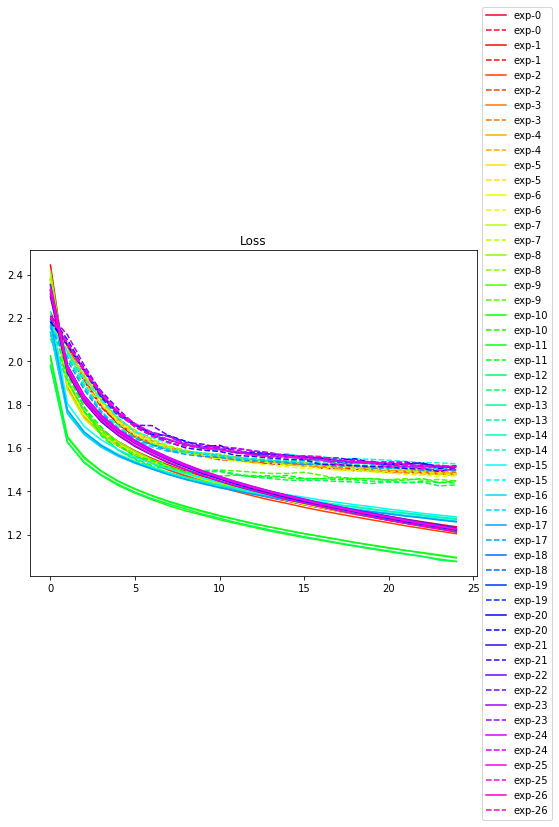

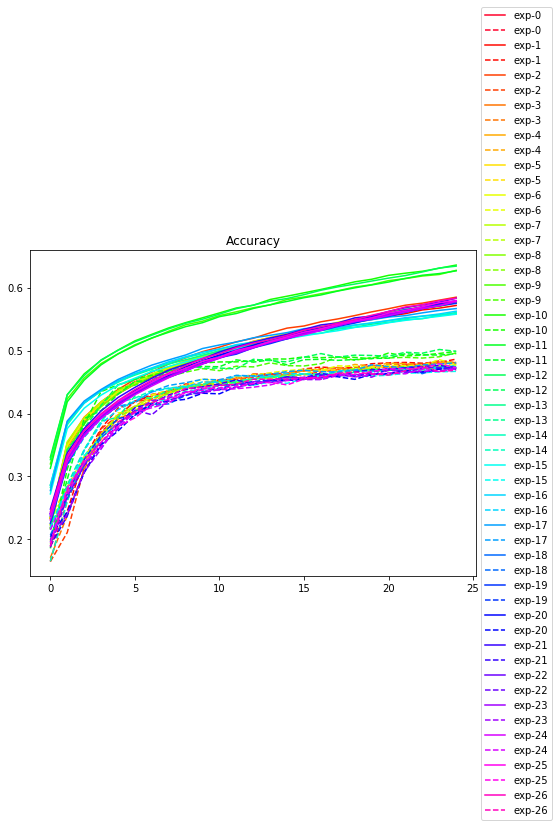

In [15]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()